<h1 align='center'>How to chose the perfect neighborhood
    for a new dental office in Toronto, Canada</h1>

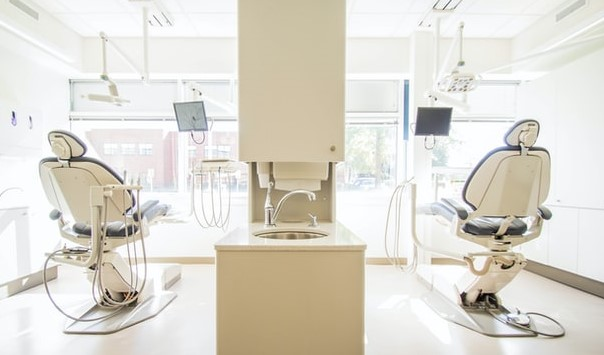<h2>Problem</h2>
<p>Imagine you are a young aspiring dentist. You studied and worked hard and now ready to go into business on your own. It is a big decision and very expensive too. The bank is willing to lend you money but wants to make sure that you can earn enough to cover the loan payments.</p> 

<p>How do you decide on the area? There are a lot of dentists out there, in every neighbourhood. How would you even compare one neighbourhood to the other? These are the questions that I will try to tackle in this project.</p>
<h2>Hypothesis</h2>
<p>I'm starting with a hypothesis that it is possible to asses and rank neighbourhoods based on the level of competition. In other words, my hypothesis is that the number of dental offices operating in each neighborhood is mostly driven by the total number of residents or households in that area. The more people live in the neighborhood, the more dentists will be required.
    </p>

<p>The first step is to gather information about the city.</p>

In [1]:
from bs4 import BeautifulSoup
import lxml
import requests
import pandas as pd
import numpy as np

<p>To get started with my research I needed to gather information about the city of Toronto and its neighborhoods. There was no relevant dataset I could find online so I decided to build it myself by scraping postal code and neigborhood data off the Wikipedia page. Postal codes without matching neighborhood names were ignored at this point.</p>

In [2]:
TO_neighborhoods = {}
scraped_data = []

info_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(info_source, 'lxml')

table_body = soup.table.tbody
rows = table_body.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    try:
        if cols[1] != 'Not assigned':
            scraped_data.append(cols)
    except:
        pass

df = pd.DataFrame(scraped_data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [3]:
print(df.dtypes)
df.describe(include='all')

PostalCode      object
Borough         object
Neighborhood    object
dtype: object


,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M8X,North York,Downsview
freq,1,24,4


<p>As you can see, Toronto has 10 boroughs consisting of 98 distinct neighborhoods. North York is the largest borough, consisting of with 24 neighborhoods</p>
<p>Next step, we download geospatial information for each postal code. We will use this information to access Foursquare database</p>

In [4]:
file_path = 'https://cocl.us/Geospatial_data'
postal_codes = pd.read_csv(file_path, delimiter=',', index_col=0)
postal_codes.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [5]:
Latitude = []
Longitude = []

for postal_code in df.PostalCode:
    Latitude.append(postal_codes.loc[postal_code, 'Latitude'])
    Longitude.append(postal_codes.loc[postal_code, 'Longitude'])

df['Latitude'] = Latitude
df['Longitude'] = Longitude

df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<p>We are going to limit our research to North York area of the city. There is no need to keep the entire dataframe so I'm reducing it to include only the information pertaining to North York</p>

In [6]:
NorthYork = df[df['Borough'] == 'North York'].reset_index(drop=True)
NorthYork.shape

(24, 5)

In [10]:
NorthYork.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


<p>Some of you may not be familiar with Toronto so let's show these neighborhoods on a map of Toronto. To that we will use Folium library</p>

In [49]:
!conda install -c conda-forge folium --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

In [50]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

In [51]:
NY_lat = 43.7615 # Latitude and Lonhitude for North York found via Google Search
NY_lng = -79.4111

NorthYork_map = folium.Map(location=[NY_lat, NY_lng], zoom_start=11)

# add markers to map
for lat, lng, label in zip(NorthYork['Latitude'], NorthYork['Longitude'], NorthYork['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NorthYork_map)  
    
NorthYork_map

<p>Now it's time to find the total number of dentist in North York. For this I used Foursquare database</p>

In [17]:
CLIENT_ID = 'M4TNBJUR44CJXBGIOAEXYHNGRMN35RLF2U1NGFKKD1M45GRE' 
CLIENT_SECRET = 'IZHZCAXHTTJ5ARDMZYSEUHNE2DPERKGBT3NNEMXUTL43DFFE'
VERSION = '20200101' # Foursquare API version

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    limit = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
    
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d178941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

    return(nearby_venues)

In [41]:
NorthYork_venues = getNearbyVenues(names=NorthYork['Neighborhood'],
                                   latitudes=NorthYork['Latitude'],
                                   longitudes=NorthYork['Longitude']
                                  )

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview
York Mills, Silver Hills
Downsview
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale
Downsview
York Mills West
Willowdale


In [42]:
NorthYork_venues.shape

(34, 7)

In [43]:
NorthYork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Glencairn,43.709577,-79.445073,Dr. Zaric Dental Office,43.709320,-79.443570,Dentist's Office
1,Don Mills,43.725900,-79.340923,Don Mills-Eglinton Dental Centre,43.724642,-79.336822,Dentist's Office
2,Don Mills,43.725900,-79.340923,Dr.Kim Dentist,43.723659,-79.337128,Dentist's Office
3,Don Mills,43.725900,-79.340923,Dr.Yuh Dentist,43.723629,-79.337015,Dentist's Office
4,Don Mills,43.725900,-79.340923,Dr. Corina Coroian Family Dentistry,43.723832,-79.336395,Dentist's Office


In [44]:
NorthYork_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",3,3,3,3,3,3
Don Mills,4,4,4,4,4,4
"Fairview, Henry Farm, Oriole",11,11,11,11,11,11
Glencairn,1,1,1,1,1,1
Humber Summit,1,1,1,1,1,1
"Northwood Park, York University",1,1,1,1,1,1
Willowdale,8,8,8,8,8,8
York Mills West,1,1,1,1,1,1


<p>As you can see clearly from the table above, Foursquare doesn't have all the listings in its database. I researched several publicly available datasets but the only source with reliable data I could find was yellowpages.com. There was no public API available to download necessary data so I used web scraping again</p>

In [11]:
import time
scraped_data = []

for page in range(1, 76):
    info_source = requests.get('https://www.yellowpages.ca/search/si/{}/Dentist/North+York+ON'.format(page)).text
    soup = BeautifulSoup(info_source, 'lxml')

    all_listings = soup.find('div', class_="resultList jsResultsList jsMLRContainer")
    singleListings = all_listings.find_all('div', class_="listing_right_section")

    for listing in all_listings.find_all('div', class_="listing__right hasIcon"):
        try:
            dentistName = listing.find('a', class_="listing__name--link listing__link jsListingName").text
            dentistAddress = listing.find('span', itemprop="streetAddress").text
            dentistPostalCode = listing.find('span', itemprop="postalCode").text
            dentistPostalCode = dentistPostalCode.split()[0]
        except:
            pass
        scraped_data.append([dentistName, dentistAddress, dentistPostalCode])
    time.sleep(0.3)

dentists_df = pd.DataFrame(scraped_data, columns=['Dentist', 'Address','Postal Code'])
dentists_df.head()

,Dentist,Address,Postal Code
0,Michael Chernick,1593 Wilson Ave,M3L
1,Fairview Mall Dental Centre,1800 Sheppard Ave E,M2J
2,Champagne Dental,2 Champagne Dr,M3J
3,Lever Barry Dr,1090 Don Mills Rd,M3C
4,Dentistry on Dufferin,2992 Dufferin St,M6B


In [12]:
dentists_df.shape

(1460, 3)

<p>While reviewing the dataset I noticed that some dentists were listed twice for those who paid to have their listing at the top of the page. Lets remove such duplicates</p>

In [13]:
dentists_df.drop_duplicates(keep='first', inplace=True)
dentists_df.shape

(1171, 3)

<p>Some dental offices have more than one dentist working there. Convinience matters and so, even if there is a large dental office within a 5-10 minute drive from your home you may prefer to go a solo practitioner who is within a walking distance from you. At this point I've decided to narrow my dataset to include only dental offices.</p>

In [14]:
dentists_df.drop_duplicates(['Address'], keep='first', inplace=True)
dentists_df.shape

(995, 3)

In [102]:
dentists_df.to_csv('dentists_North_York.csv')

<p>We don't need to know the names of the clinics, just the total number per postal code.</p>

In [15]:
dentists_grp = dentists_df.groupby(['Postal Code'], as_index=False).count()
dentists_grp.head(10)

,Postal Code,Dentist,Address
0,L3R,46,46
1,L3S,3,3
2,L3T,22,22
3,L4B,21,21
4,L4C,42,42
5,L4H,4,4
6,L4J,36,36
7,L4K,22,22
8,L4L,21,21
9,L4S,3,3


<h3>Now we need to get the sense of the total number of residents living in North York</h3>

In [16]:
# Data source: Population and Dwelling Count Highlight Tables, 2016 Census
link = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV'

population = pd.read_csv(link , usecols = [1,2,3,4,5], header=0)
population = population[['Geographic name', 'Population, 2016', 'Total private dwellings, 2016']]
population = population.rename(columns={'Geographic name':'Postal Code'})
population.head()

,Postal Code,"Population, 2016","Total private dwellings, 2016"
0,Canada,35151728.0,15412443.0
1,A0A,46587.0,26155.0
2,A0B,19792.0,13658.0
3,A0C,12587.0,8010.0
4,A0E,22294.0,12293.0


<p>Let's merge both dataframes</p>

In [17]:
df_final = pd.merge(dentists_grp, population, on='Postal Code', how='left')
df_final = df_final.drop(columns=['Address'])
df_final = df_final.rename(columns={'Dentist':'Number of Dentists', 'Population, 2016':'Number of Residents', 'Total private dwellings, 2016':'Number of Households'})
df_final.head()

,Postal Code,Number of Dentists,Number of Residents,Number of Households
0,L3R,46,62298.0,20441.0
1,L3S,3,56117.0,14906.0
2,L3T,22,50669.0,20181.0
3,L4B,21,35858.0,12367.0
4,L4C,42,71152.0,27583.0


In [18]:
df_final['Dentists per 1000 people'] = df_final['Number of Dentists'] / (df_final['Number of Residents'] / 1000)
df_final['Dentists per 1000 Households'] = df_final['Number of Dentists'] / (df_final['Number of Households'] / 1000)

In [26]:
df_final.describe()

,Number of Dentists,Number of Residents,Number of Households,Dentists per 1000 people,Dentists per 1000 Households
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,10.473684,31367.621053,12920.200000,inf,34.652136
std,8.796569,18097.748451,6819.246992,NaN,308.154223
min,1.000000,0.000000,1.000000,0.015127,0.047717
25%,4.500000,18434.500000,8223.500000,0.171966,0.372954
50%,8.000000,28522.000000,12207.000000,0.288157,0.695806
75%,14.500000,41017.500000,16391.000000,0.479672,1.130647
max,46.000000,85794.000000,36123.000000,inf,3000.000000


<p>There are some outliers in our dataset which we need to eliminate.</p>

In [28]:
df_final = df_final[df_final['Dentists per 1000 Households'] <= 3]

In [29]:
df_final.describe()

,Number of Dentists,Number of Residents,Number of Households,Dentists per 1000 people,Dentists per 1000 Households
count,89.000000,89.000000,89.000000,89.000000,89.000000
mean,10.393258,33133.752809,13626.505618,0.355617,0.791422
std,8.847981,17250.582116,6428.292628,0.303479,0.569299
min,1.000000,5997.000000,2290.000000,0.015127,0.047717
25%,5.000000,20039.000000,9274.000000,0.170692,0.367354
50%,7.000000,31583.000000,12797.000000,0.274760,0.628843
75%,14.000000,41243.000000,16597.000000,0.453241,1.078283
max,46.000000,85794.000000,36123.000000,1.662116,2.620087


<p>Let's sort the dataset and plot it to see if there is a clear pattern.</p>

In [41]:
df_final.sort_values(['Dentists per 1000 Households'], ascending=False, axis=0, inplace=True)

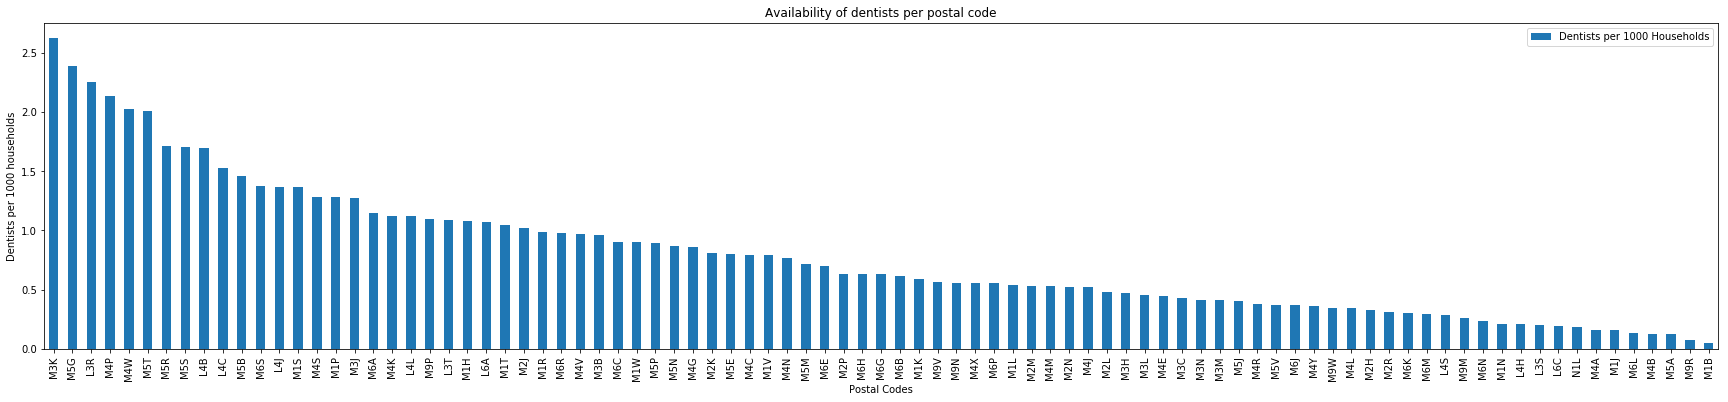

In [42]:
import matplotlib.pyplot as plt
df_final.plot(kind='bar', x='Postal Code', y='Dentists per 1000 Households', figsize=(30,6))
plt.xlabel('Postal Codes')
plt.ylabel('Dentists per 1000 households')
plt.title('Availability of dentists per postal code')
plt.show()

<p>Unfortunately there is no clear pattern observable. Checking if there is a linear relationship between the number of dentists and the total number of households in each postal code</p>

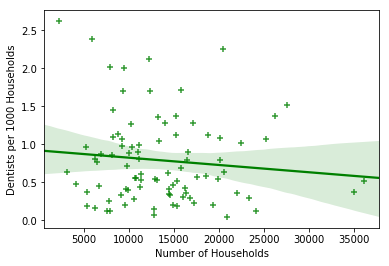

In [40]:
import seaborn as sns
ax = sns.regplot(x='Number of Households', y='Dentists per 1000 Households', data=df_final, color='green', marker='+')

<p>At this point we can disprove our hypothesis that the number of dental offices in each neighborhood is dependent on the total number of households in the area.</p> 
<p>Just to be absolutely sure, let's see if there is a linear relationship between the total number of dental offices, total number of residents and total number of households. We assume that population density (Number of residents / number of households) may be dependent on whether the area has more apartment buildings vs single homes. Single homes should have higher density per household.</p>

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
lm = LinearRegression()

In [46]:
x = df_final[['Number of Residents', 'Number of Households']]
y = df_final['Number of Dentists']

In [47]:
lm.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
lm.score(x, y)

0.24616174428011295

<p>R-square of 0.24 confirms that there is no linear relationship and we can safely disprove our hypothesis</p>